# Técnica de voronoi com pontos mais próximos do polígono

Nesse notebook vamos experimentar uma técnica nova para tentar corrigir o excesso de polígono gerado em cruzamentos de grandes vias

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (40, 30)

df_qf = gpd.read_file(f'gis/SIRGAS_SHP_quadraMDSF.shp')
df_qv = gpd.read_file(f'gis/SIRGAS_SHP_quadraviariaed_polygon.shp')
df_l = gpd.read_file(f'gis/SIRGAS_SHP_logradouronbl.shp')
# df_s = gpd.read_file(f'gis/SIRGAS_SHP_setorfiscal.shp')
# df_s = gpd.read_file(f'gis/SIRGAS_SHP_prefeitura_regional_polygon.shp')
# df_s = gpd.read_file(f'gis/SIRGAS_SHP_distrito_polygon.shp')
df_s = gpd.read_file(f'gis/teste-recorte-1.geojson')
# df_represas = gpd.read_file(f'gis/SIRGAS_REPRESAS_NIVELMAX.shp')
# df_massa_dagua = gpd.read_file(f'gis/SIRGAS_MASSADAGUA.shp')

In [2]:
df_s_sindex = df_s.sindex
df_l_sindex = df_l.sindex

In [3]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(df_s.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
l_candidate_idx = list(df_l_sindex.intersection(bounds))
l_candidates = df_l.loc[l_candidate_idx]

In [4]:
df_l = gpd.clip(l_candidates, df_s)

/home/fernando/miniconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


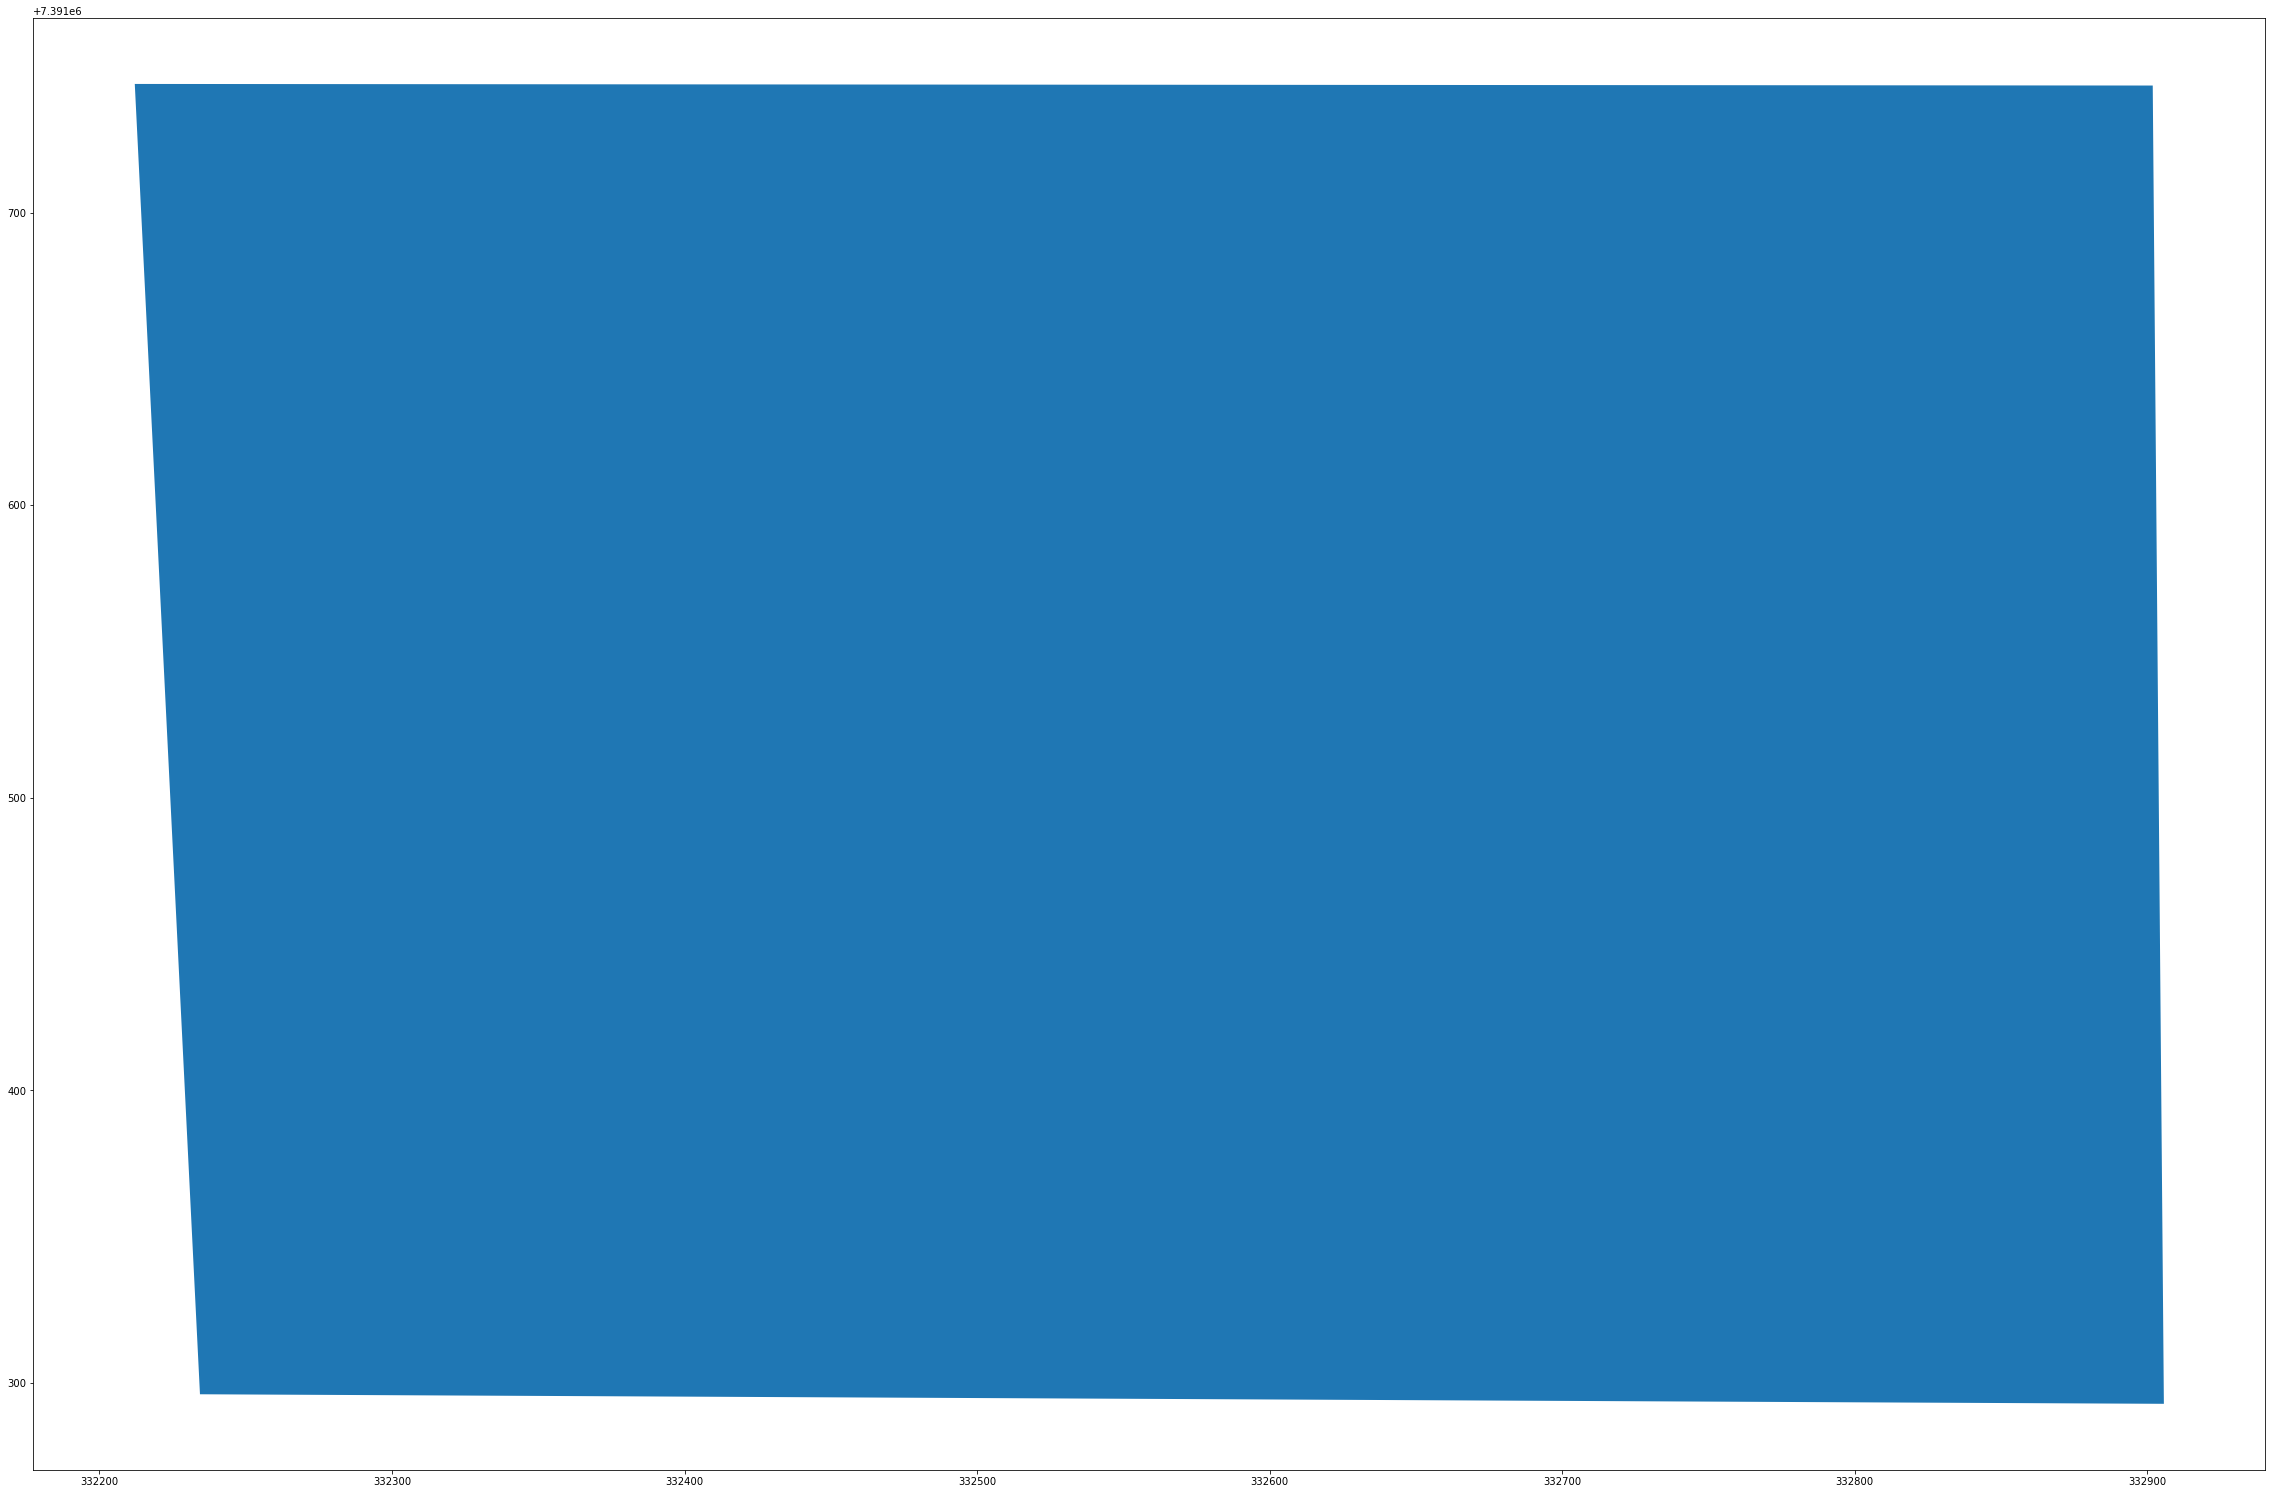

In [5]:
df_s.plot()

In [6]:
df_qv_sindex = df_qv.sindex

In [7]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(df_s.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
qv_candidate_idx = list(df_qv_sindex.intersection(bounds))
qv_candidates = df_qv.loc[qv_candidate_idx]

In [8]:
df_vias = gpd.overlay(df_s, qv_candidates, how='difference')

In [9]:
df_l_cropped = gpd.clip(l_candidates, df_vias)

/home/fernando/miniconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [10]:
df_l = df_l_cropped

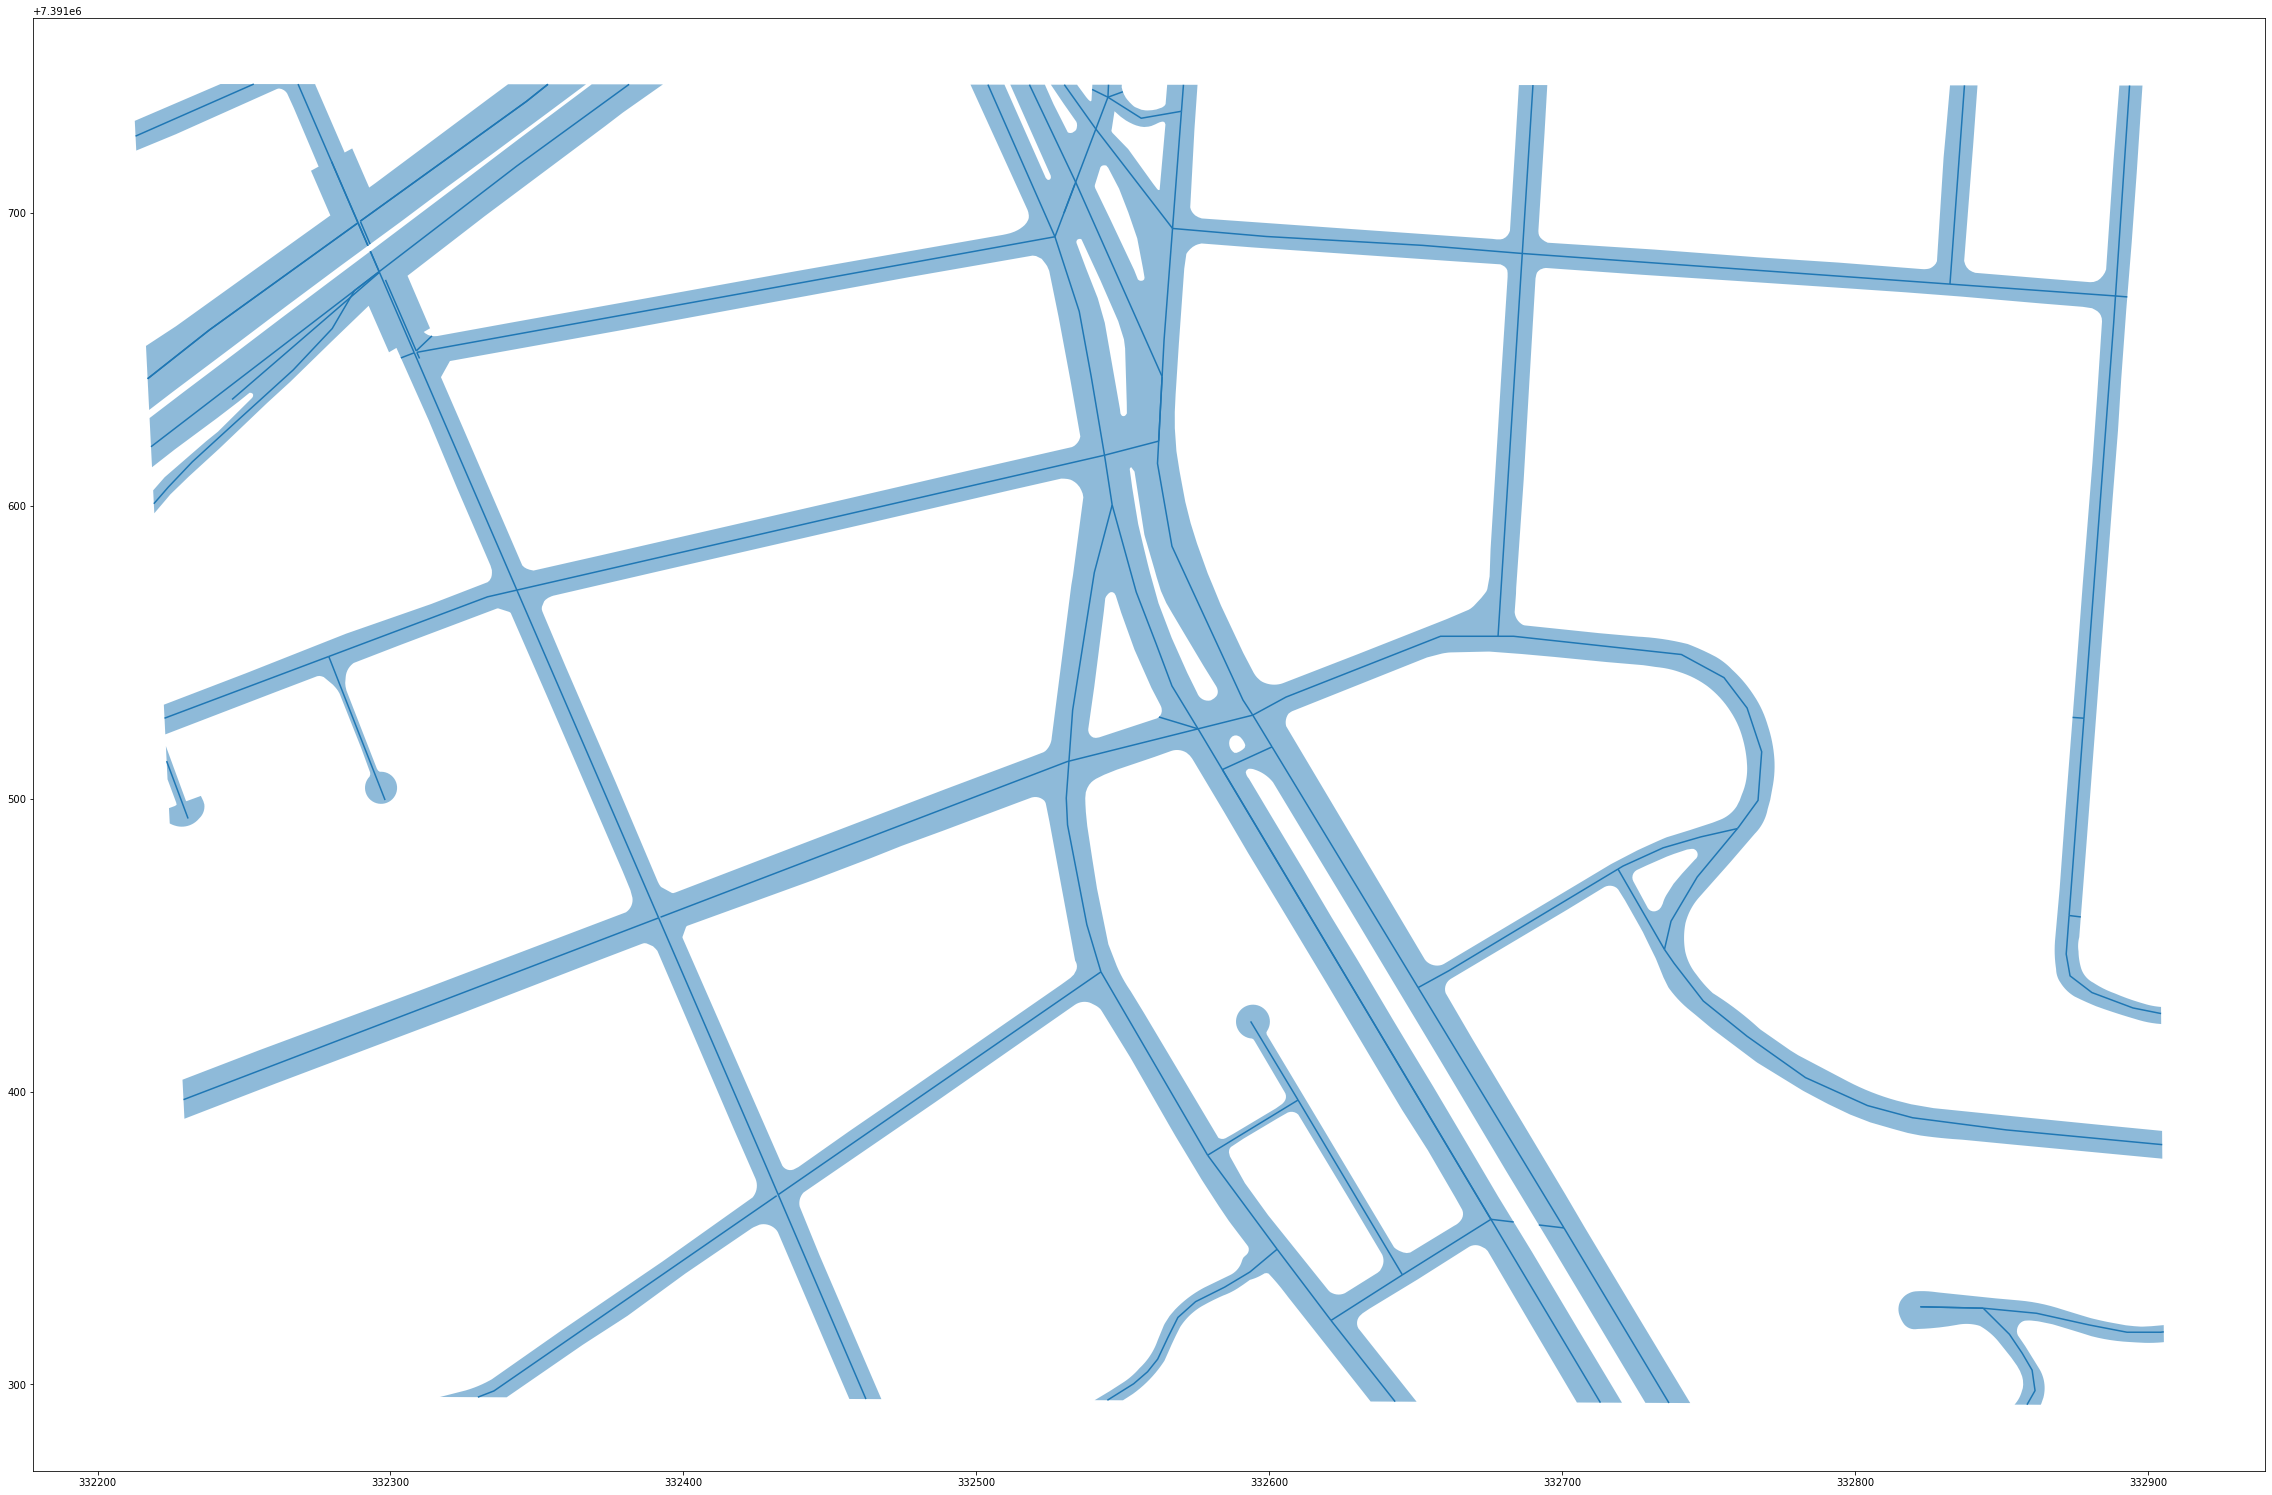

In [11]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.5)
df_l.plot(ax=ax)
# df_logradouros.plot(ax=ax)

plt.show()

In [12]:
gdf_cruzamentos_inicio = df_l[df_l['geometry'].type == 'LineString']['geometry'].map(lambda x: (x.interpolate(0, normalized=True)))
gdf_cruzamentos_final = df_l[df_l['geometry'].type == 'LineString']['geometry'].map(lambda x: (x.interpolate(1, normalized=True)))
gdf_cruzamentos =  pd.concat([gdf_cruzamentos_inicio, gdf_cruzamentos_final])
gdf_c = gdf_cruzamentos

In [13]:
cruzamentos = [p.centroid for p in gdf_c.buffer(4).unary_union]
df_cruzamentos = gpd.GeoDataFrame(geometry=cruzamentos)

In [319]:
# TODO
# Encontar pontos que não são cruzamentos
# Talvez criando um buffer removendo aqueles que cruzem duas linhas ou menos

In [14]:
ps = list(map(lambda x: [x.coords[0][0], x.coords[0][1]], df_cruzamentos.geometry))

In [15]:
from libpysal.cg.voronoi  import voronoi, voronoi_frames

In [16]:
df_voronoi_polygon, df_voronoi_point = voronoi_frames(ps)

In [45]:
df_quadras_voronoi = gpd.overlay(df_voronoi_polygon, df_vias, how='difference')

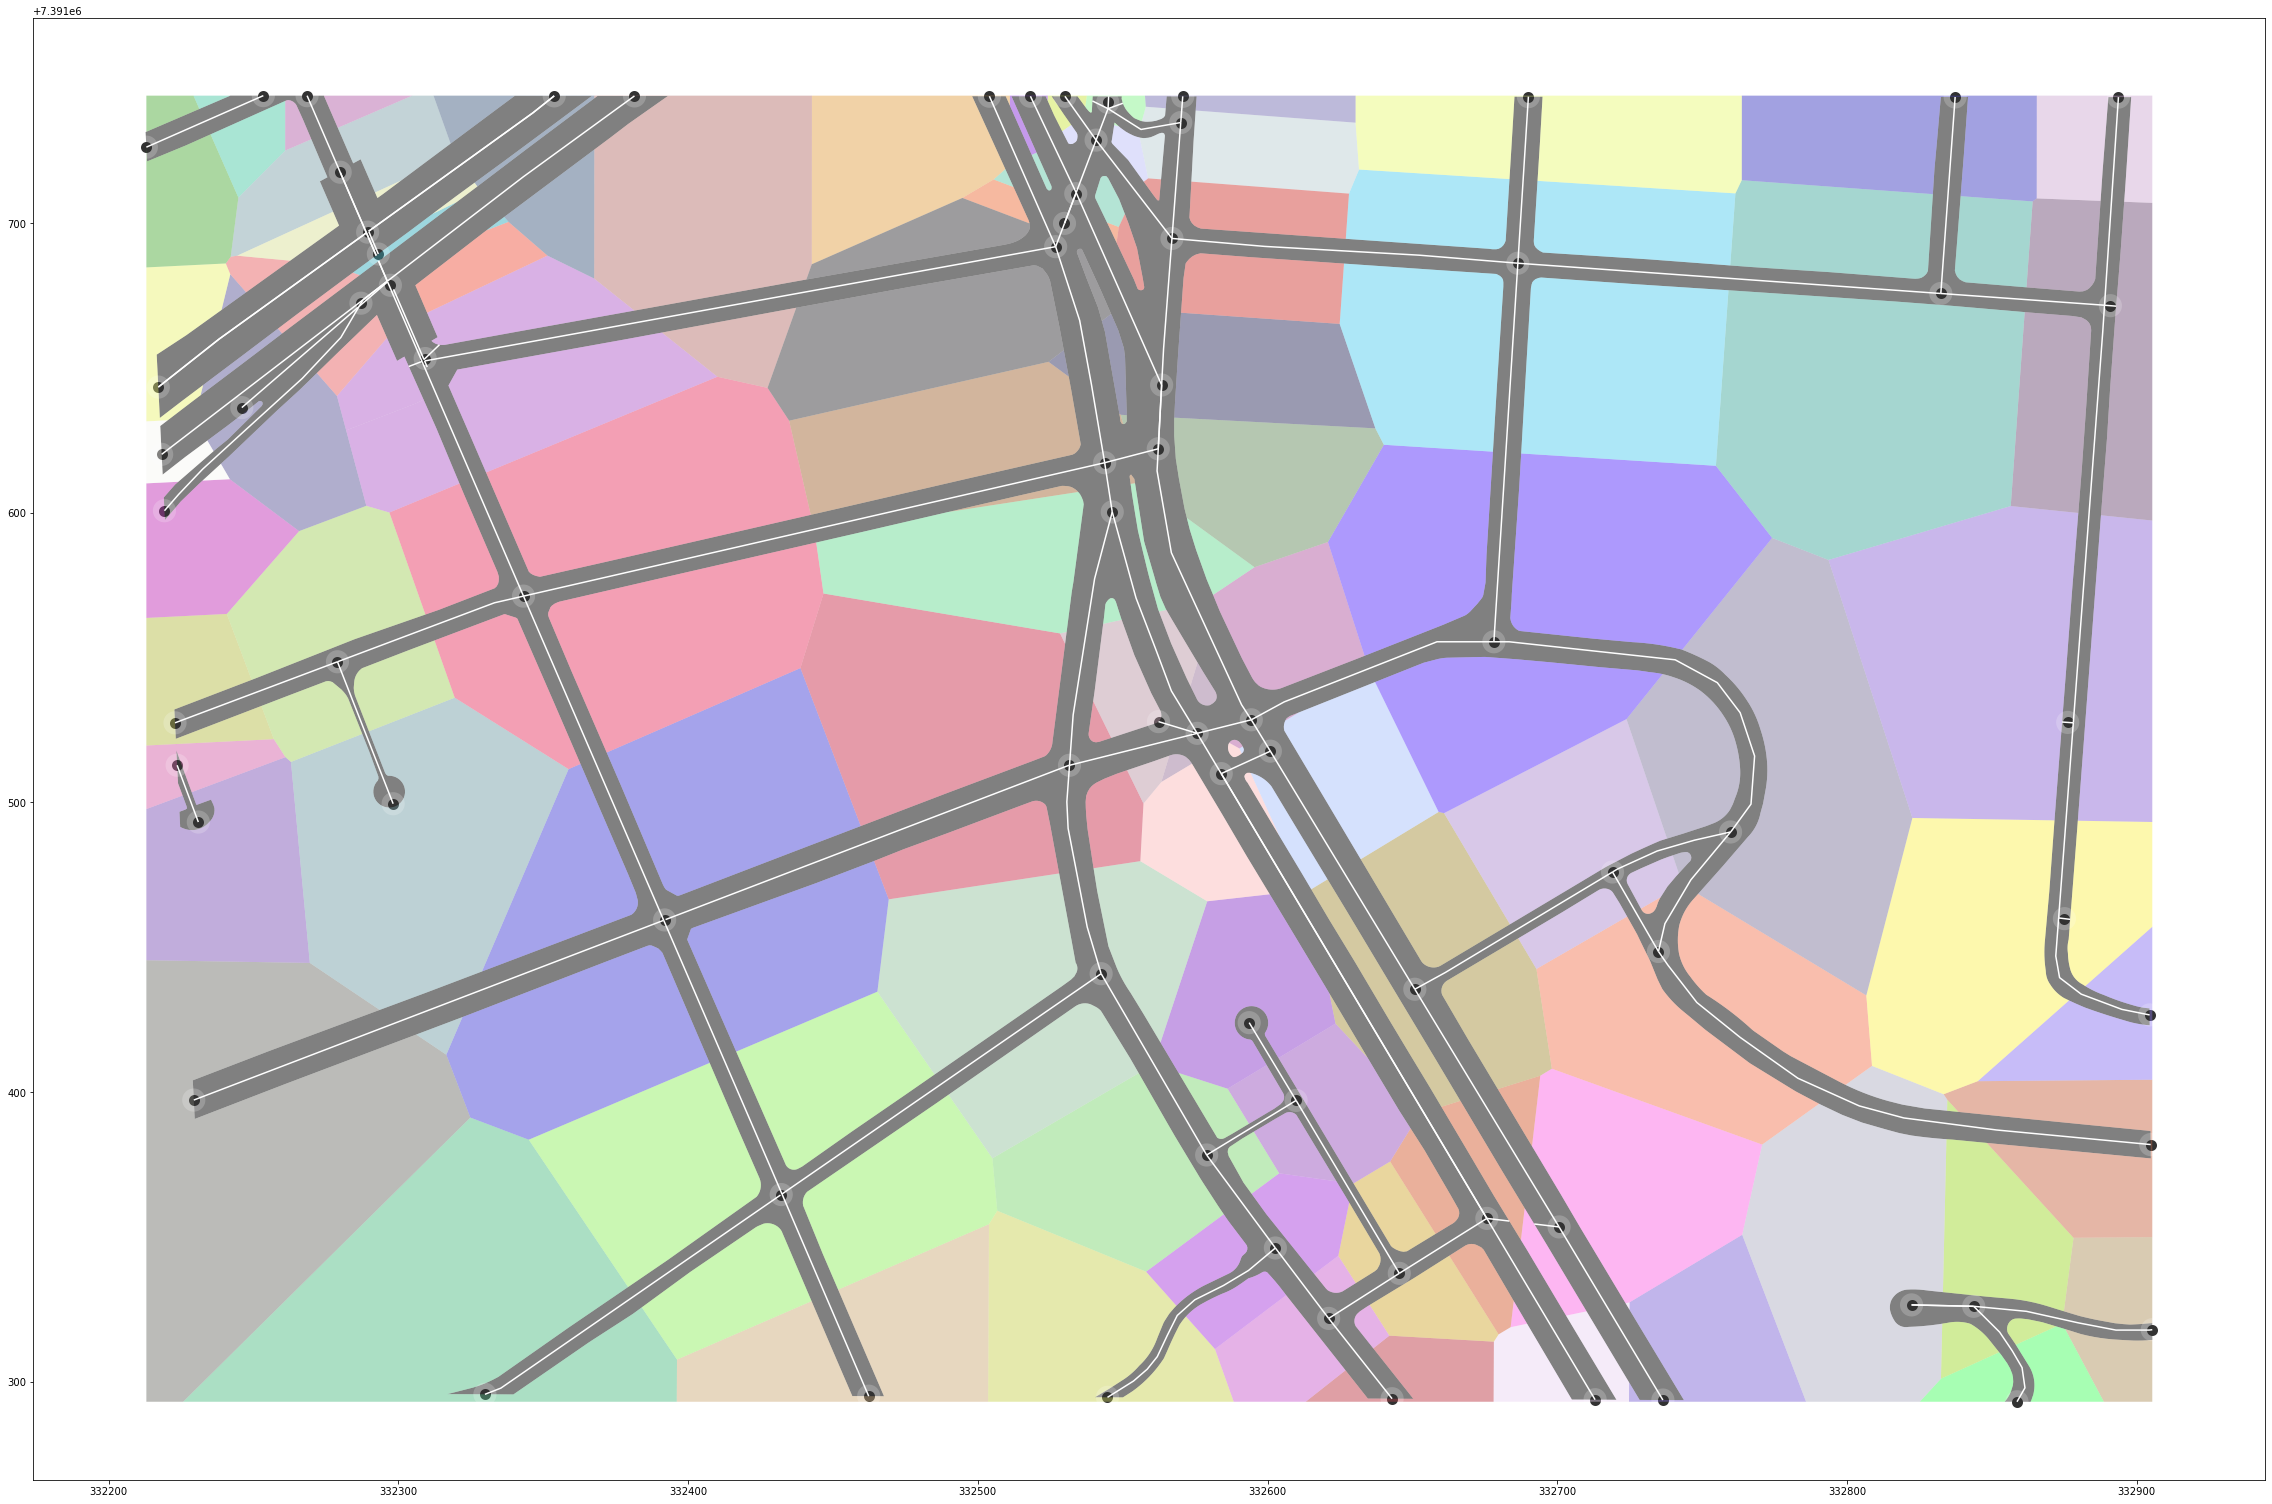

In [231]:
import numpy as np

f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=1, color='grey')
df_l.plot(ax=ax, color='white')
df_cruzamentos.plot(ax=ax, alpha=1, lw=5, color='black')
df_quadras_voronoi.plot(ax=ax, color=np.random.rand(len(df_quadras_voronoi), 3), alpha=0.4)
df_cruzamentos.buffer(4).plot(ax=ax, color='white', alpha=0.2)
# df_logradouros.plot(ax=ax)

plt.show()

In [101]:
df_quadras_voronoi['id'] = df_quadras_voronoi.index.values
df_cruzamentos['id'] = df_cruzamentos.index.values
df_cruzamentos_voronoi = df_cruzamentos.merge(df_quadras_voronoi, on='id', suffixes=('_cruzamentos', '_voronoi'))

In [186]:
df_multipolygons_voronoi = df_cruzamentos_voronoi[list(map(lambda x: x.type == 'MultiPolygon', df_cruzamentos_voronoi.geometry_voronoi))]

In [226]:
from shapely.geometry import MultiPoint, LineString, MultiLineString

pontos_proximos = list(map(lambda x: MultiLineString(list(map(lambda y: LineString(nearest_points(x.geometry_cruzamentos, y)),
                                        list(x.geometry_voronoi.geoms)))), 
                           df_multipolygons_voronoi.itertuples()))
pontos_proximos
df_pp = gpd.GeoDataFrame(geometry=pontos_proximos)

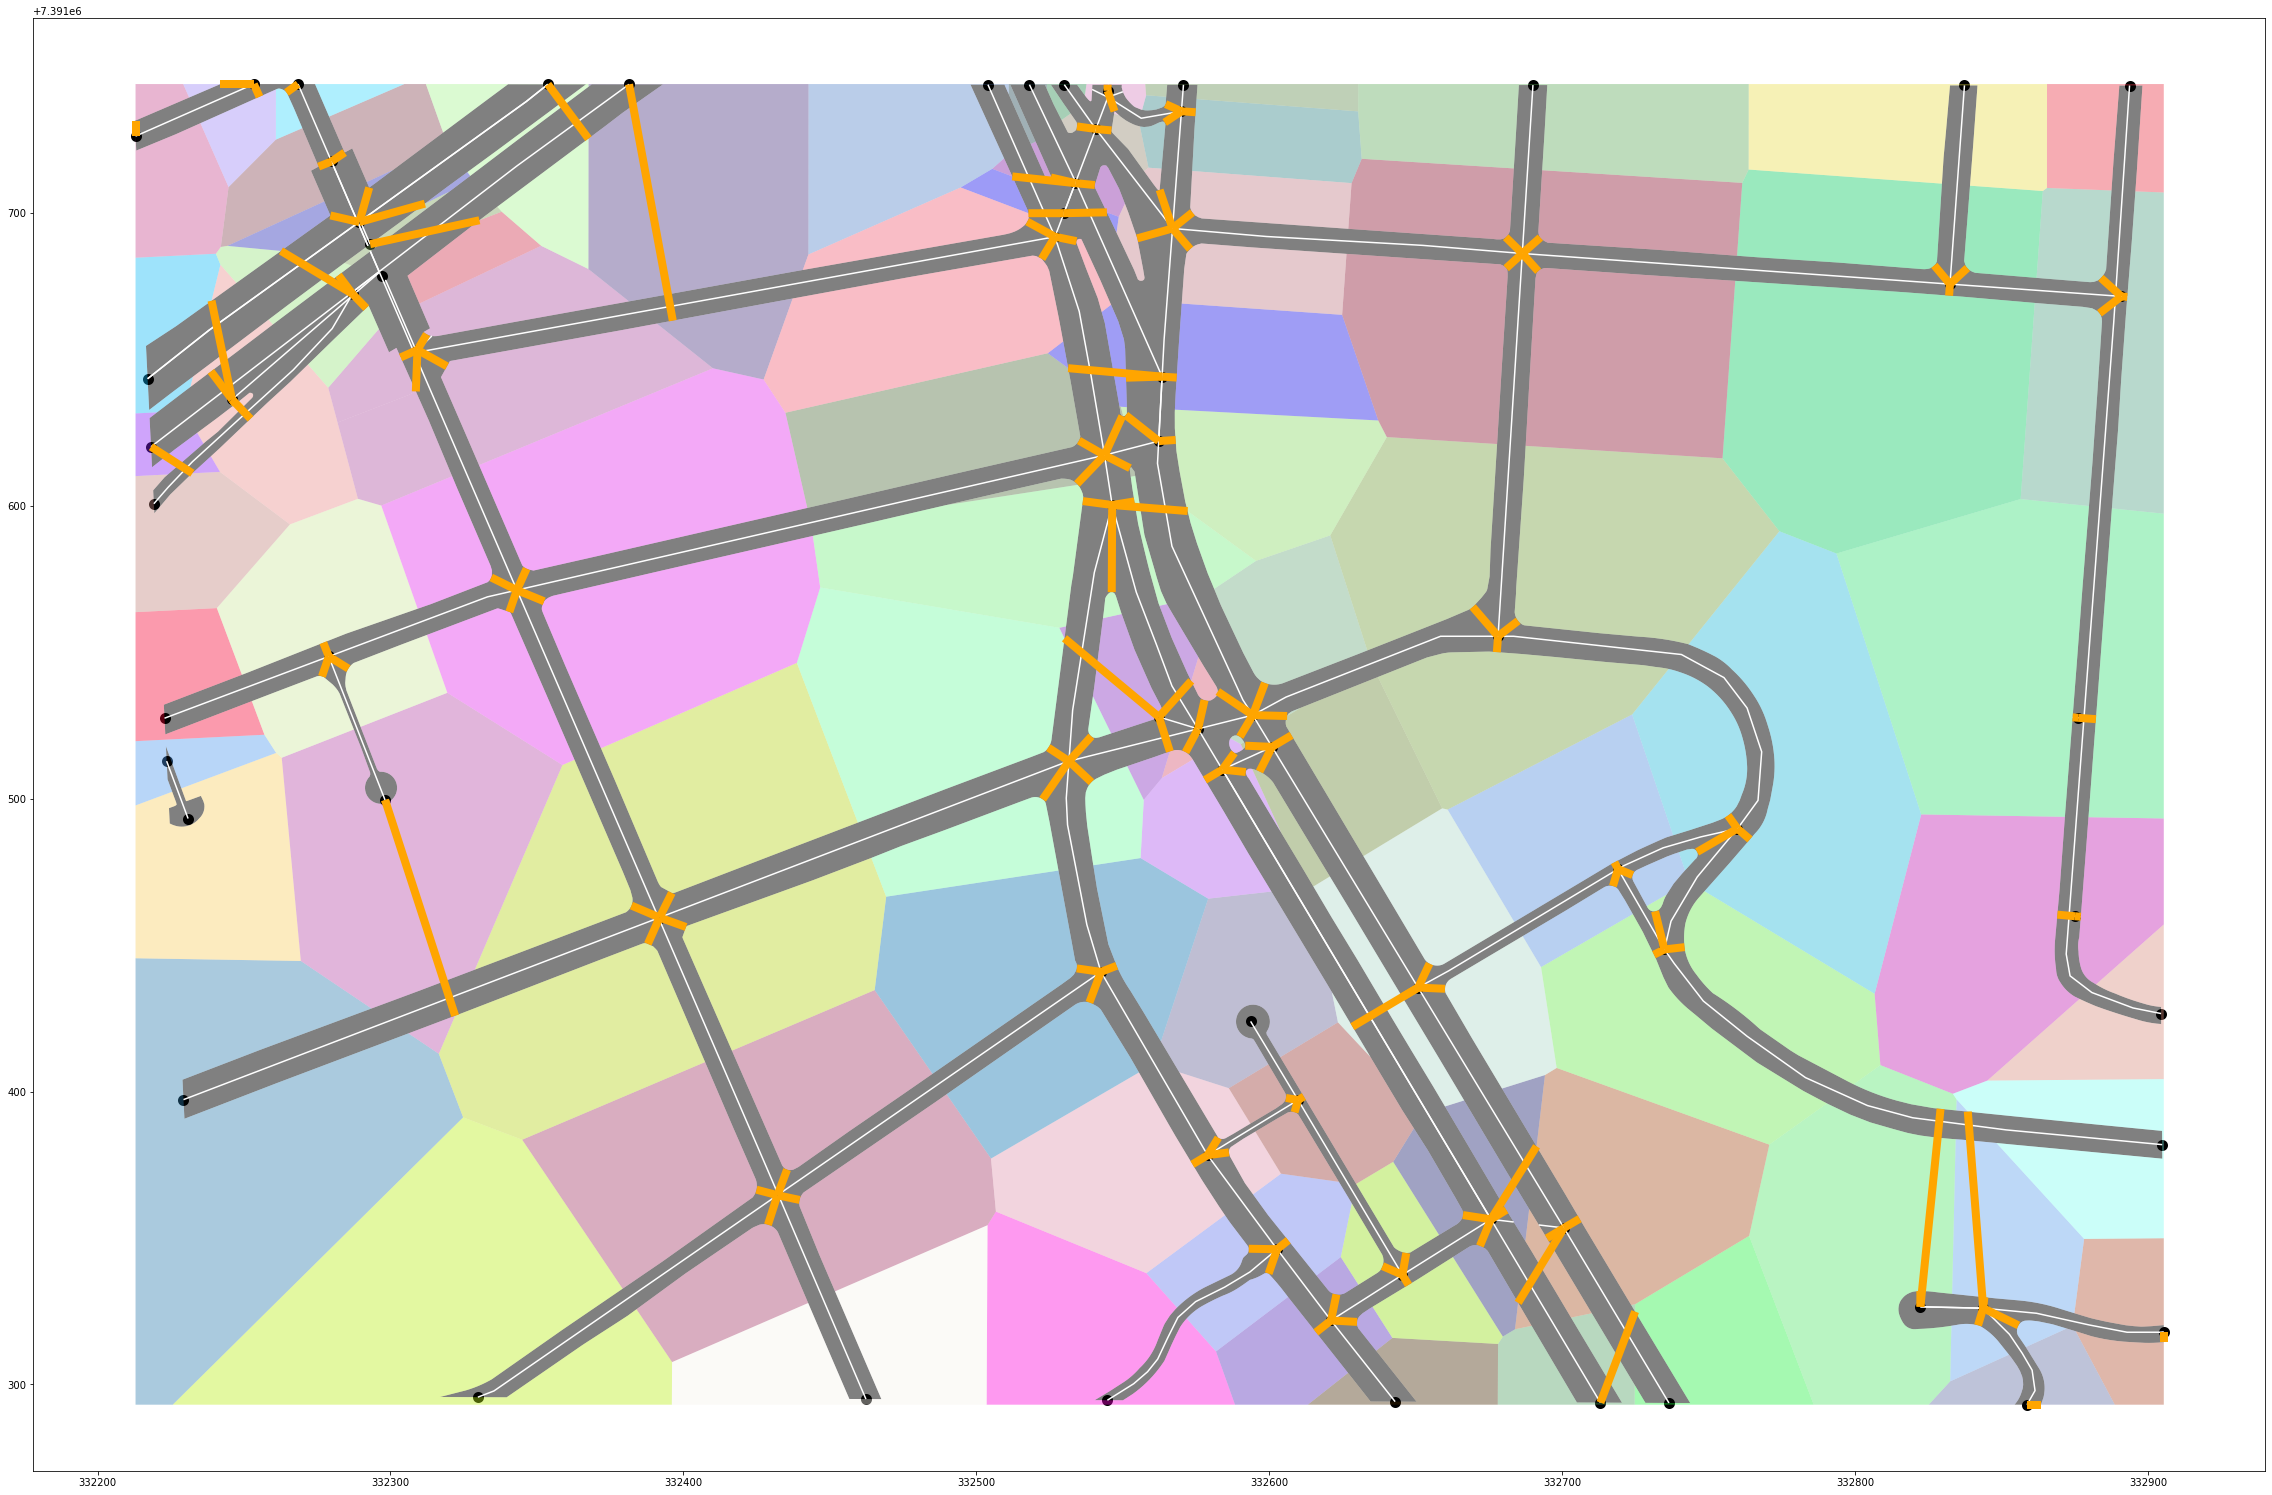

In [224]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=1, color='grey')
df_l.plot(ax=ax, color='white')
df_cruzamentos.plot(ax=ax, alpha=1, lw=5, color='black')
df_quadras_voronoi.plot(ax=ax, color=np.random.rand(len(df_quadras_voronoi), 3), alpha=0.4)
df_pp.plot(ax=ax, color='orange', lw=8)
# df_logradouros.plot(ax=ax)

plt.show()

In [326]:
df_l_out = gpd.overlay(df_l, gpd.GeoDataFrame(geometry=df_cruzamentos.buffer(8)), how='difference')

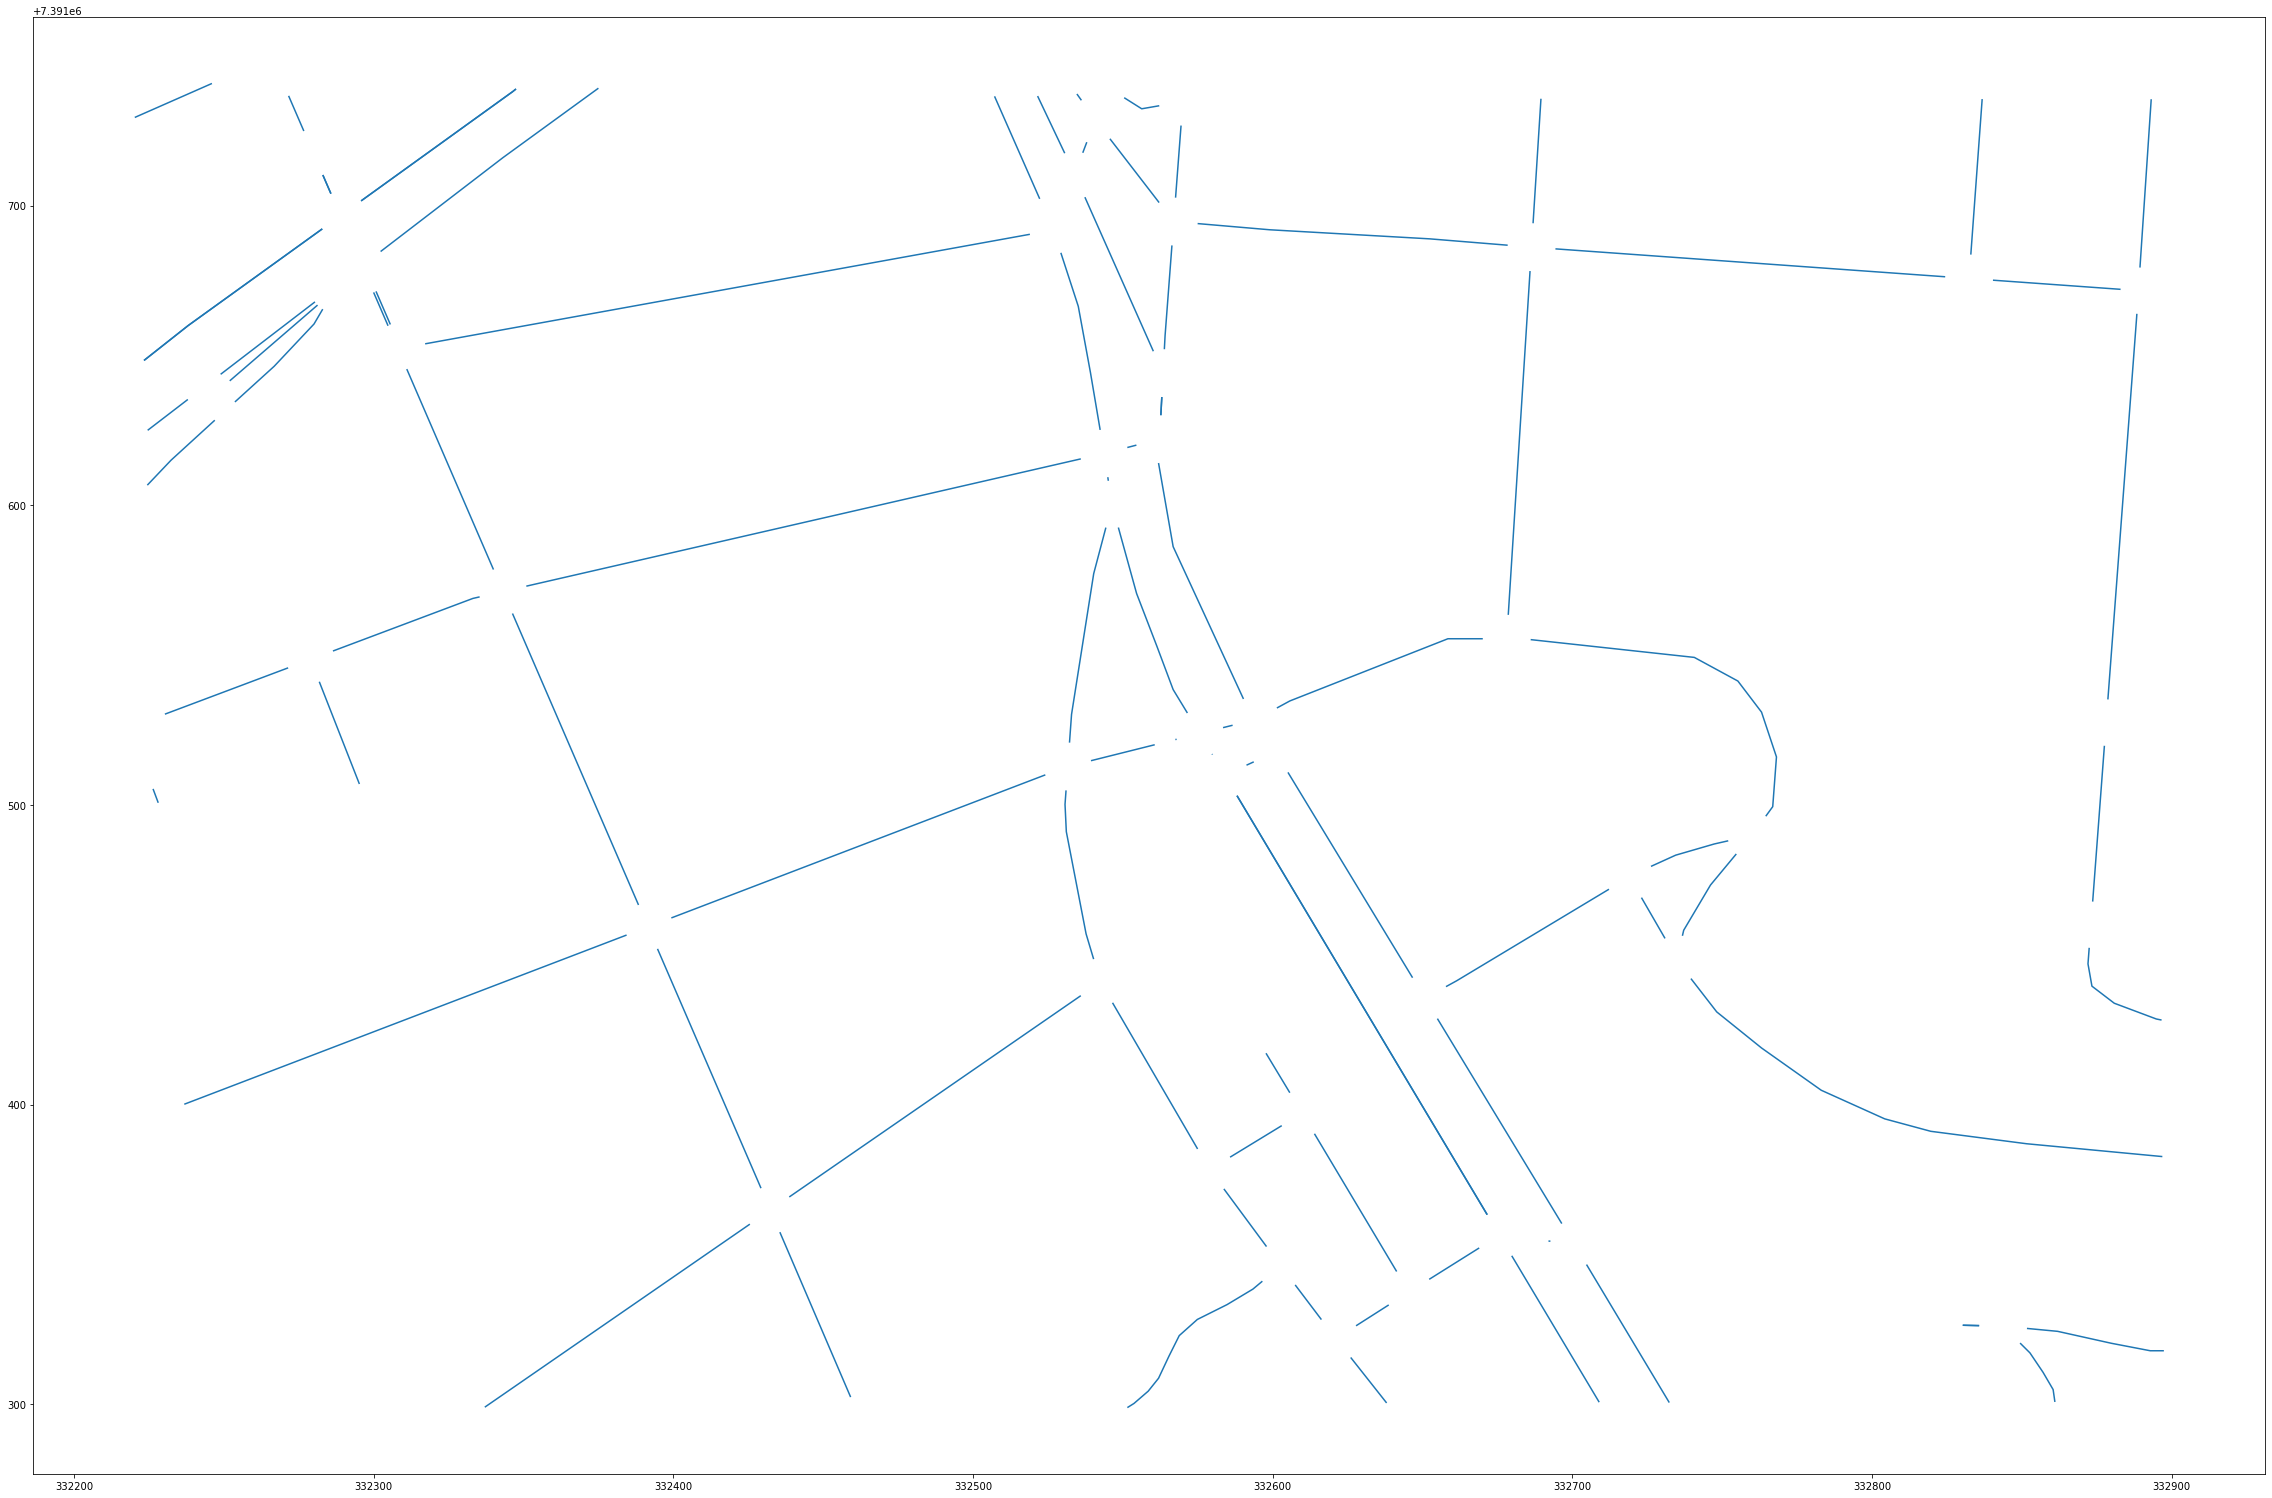

In [327]:
df_l_out.plot()

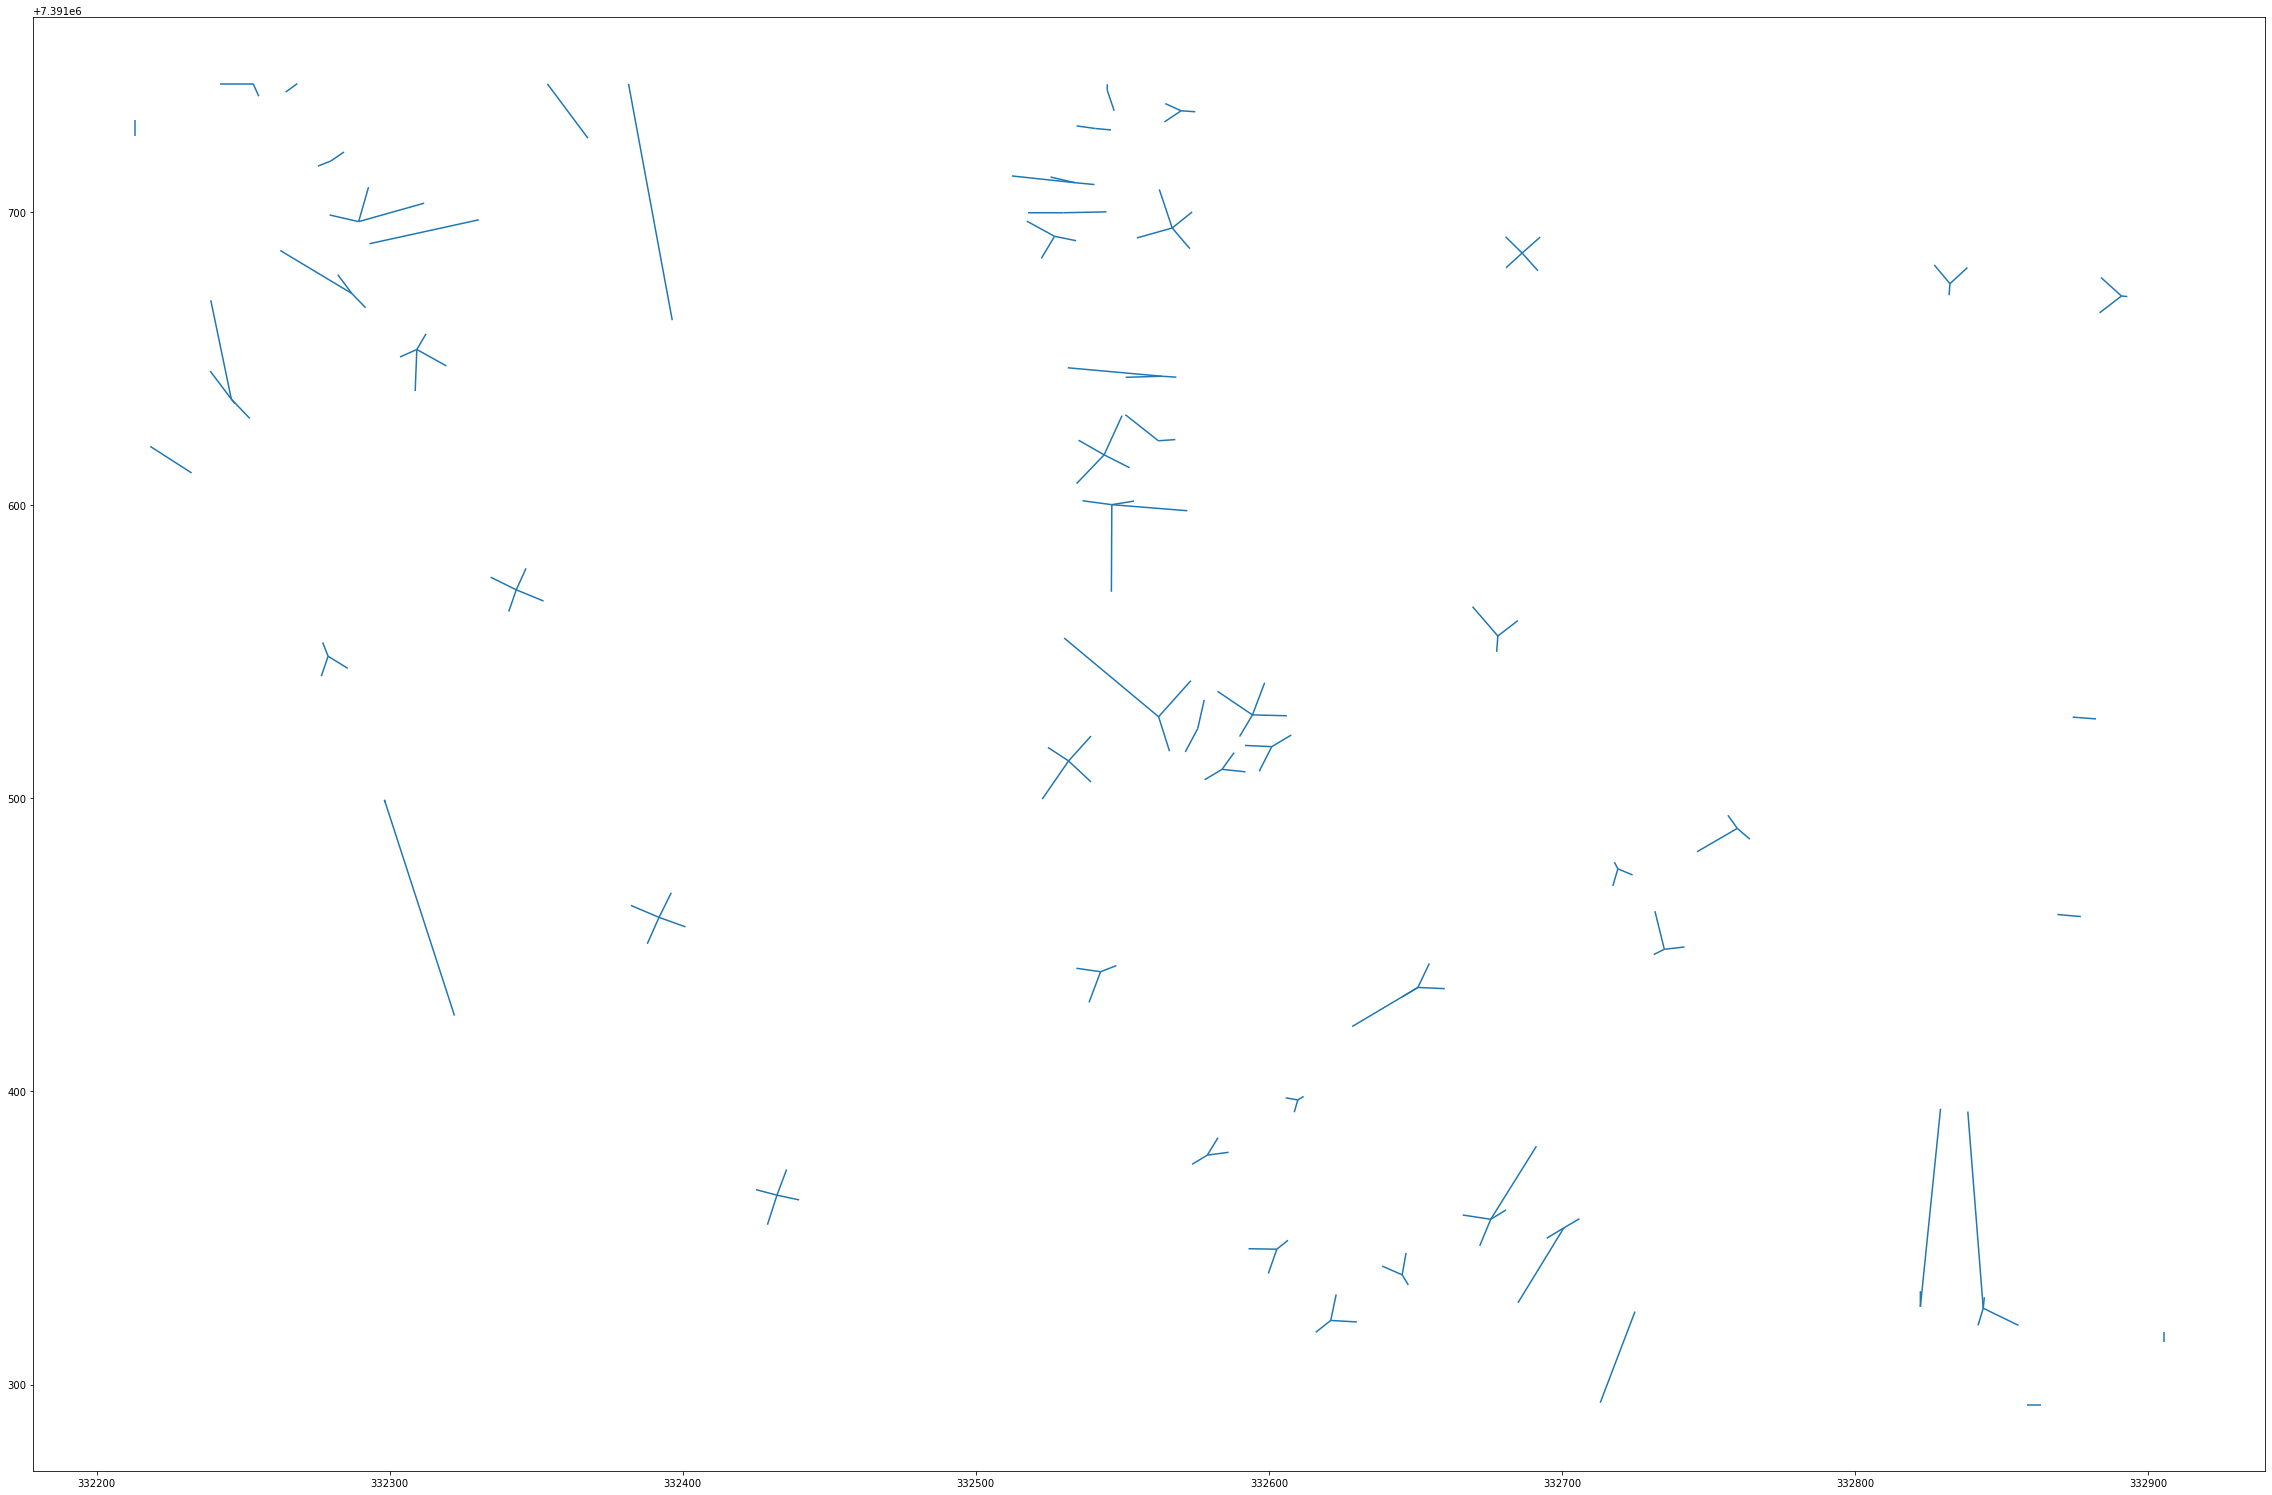

In [328]:
cut_lines = list(map(lambda x: [i for i in x.geoms], df_pp.geometry))
cut_lines_flatten = [item for sublist in cut_lines for item in sublist]
df_cut_lines = gpd.GeoDataFrame(geometry=cut_lines_flatten)
df_cut_lines.plot()

In [329]:
seila = df_cut_lines.disjoint(df_l_out.unary_union)
# seila[seila.disjoint(df_cruzamentos.buffer(4))]
# seila.disjoint(df_cruzamentos.buffer(4))




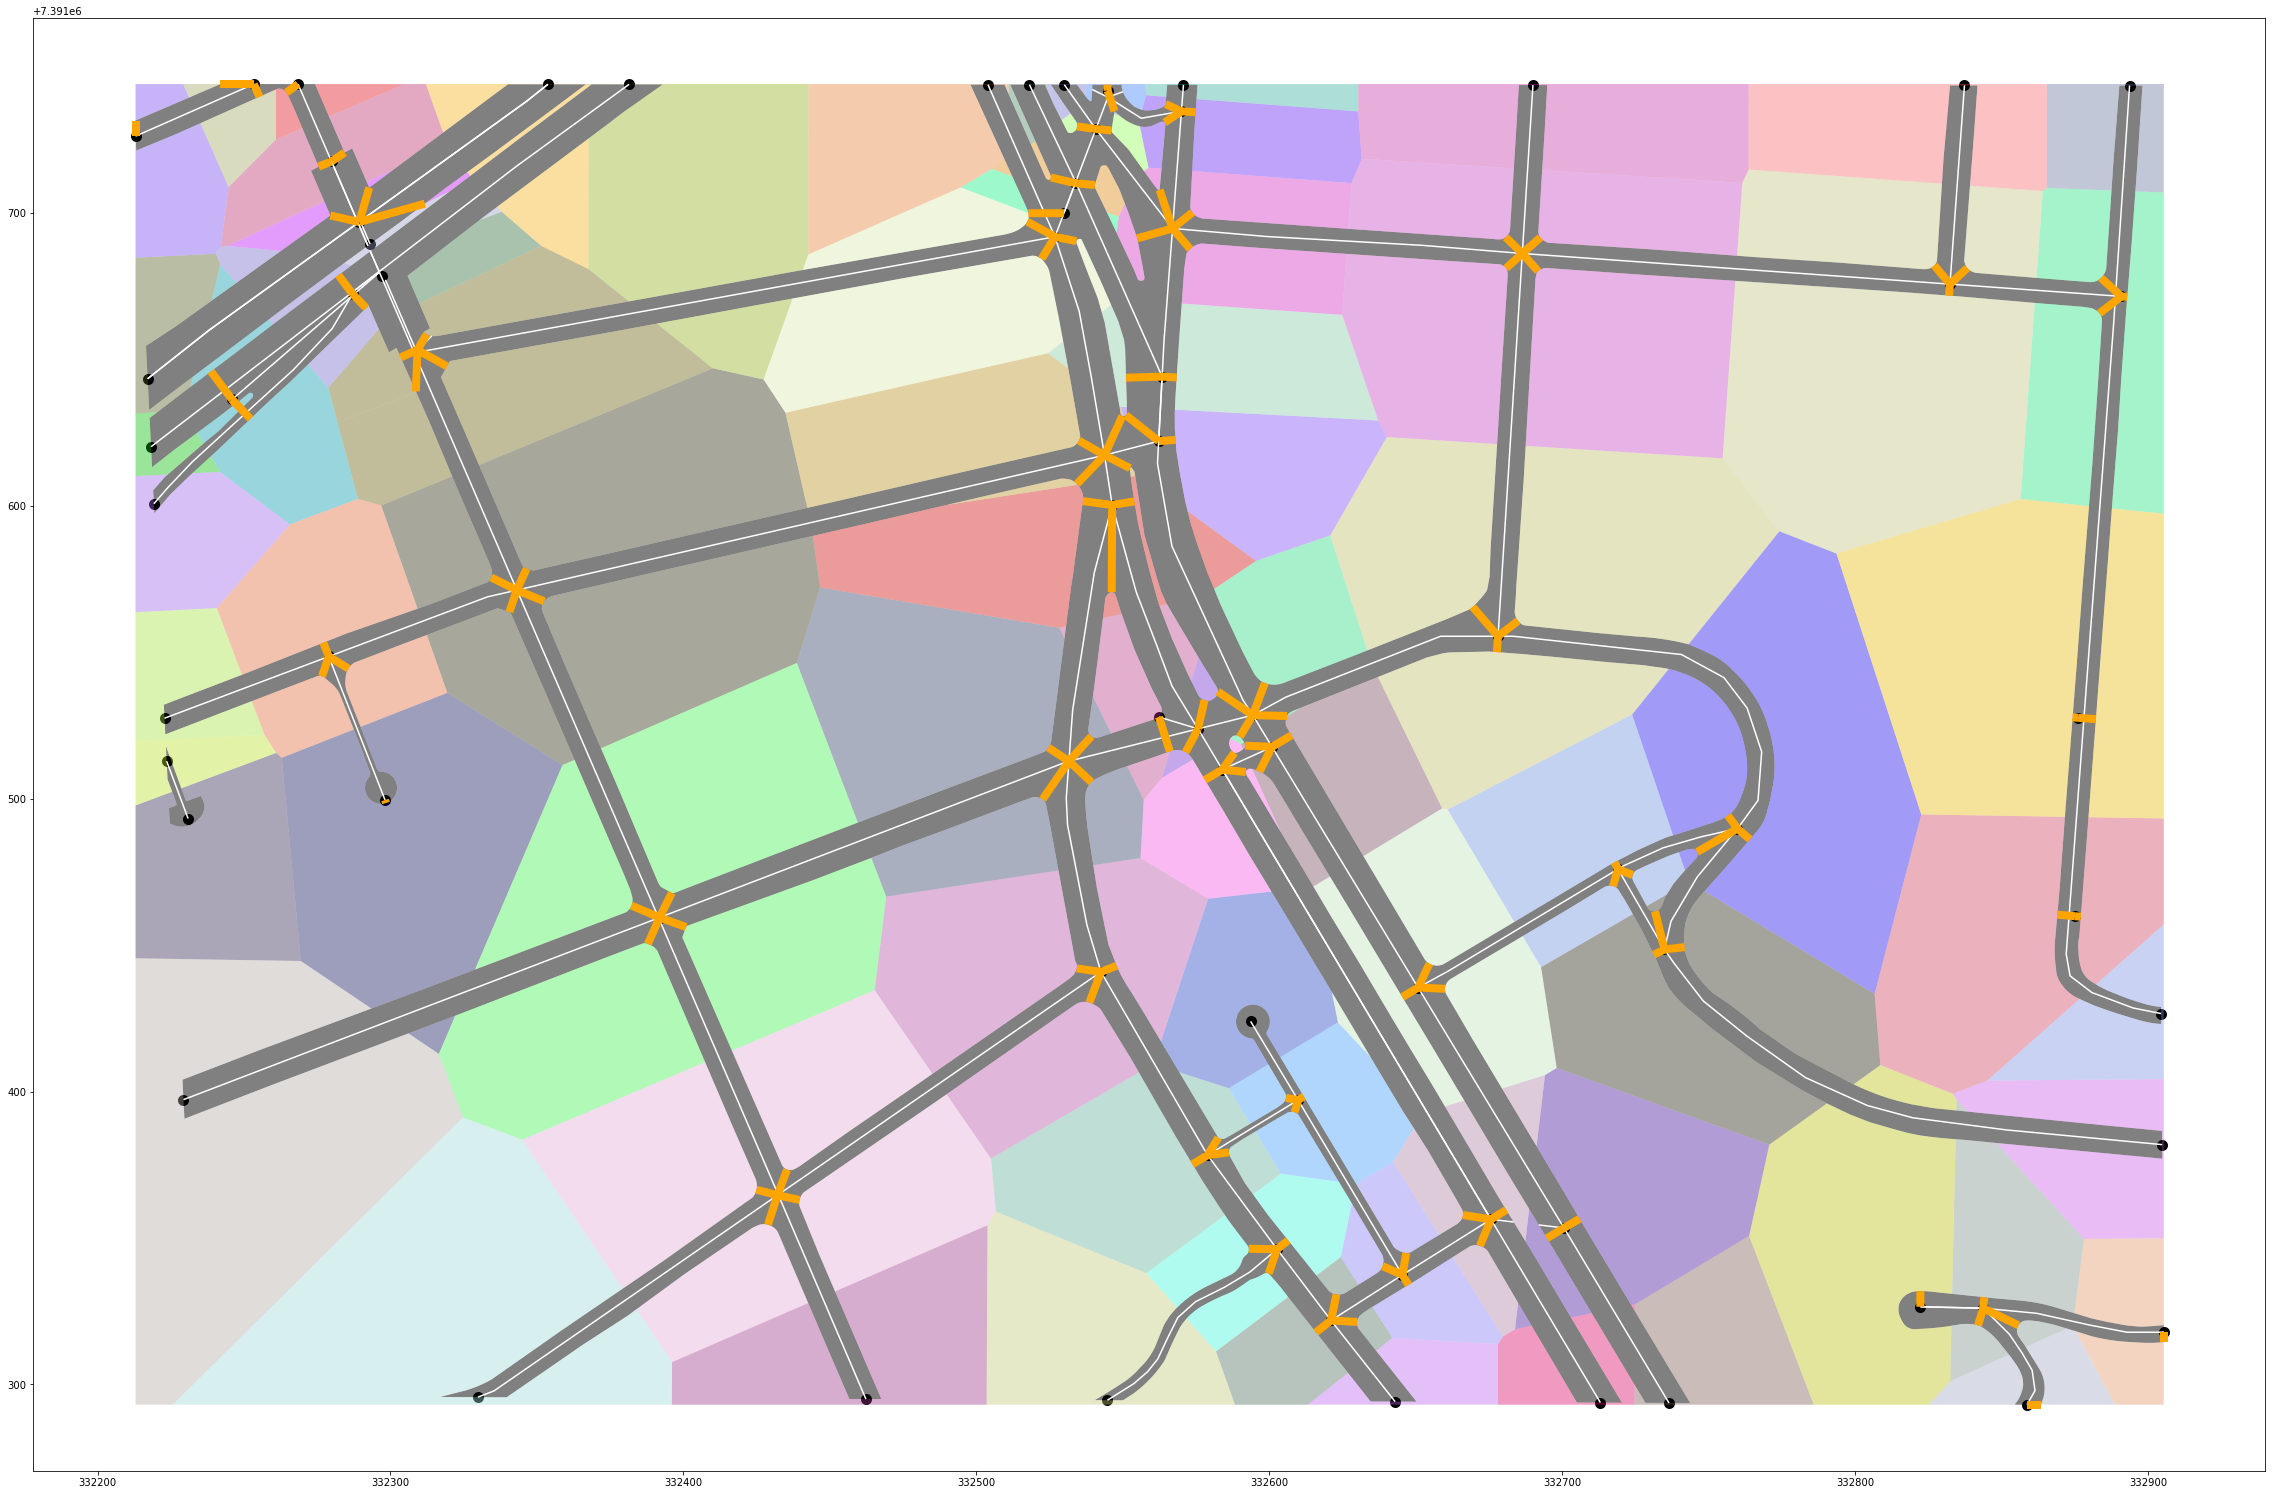

In [330]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=1, color='grey')
df_l.plot(ax=ax, color='white')
df_cruzamentos.plot(ax=ax, alpha=1, lw=5, color='black')
df_quadras_voronoi.plot(ax=ax, color=np.random.rand(len(df_quadras_voronoi), 3), alpha=0.4)
df_cut_lines[seila].plot(ax=ax, color='orange', lw=8)


plt.show()